# A/B-тестирование

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy import stats
from matplotlib import pyplot as plt

C:\Users\Alexandra\AppData\Local\Temp\ipykernel_18168\2419239010.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


A/B-тестирование — метод исследования...

In [3]:
data = pd.read_csv("../data/cookie_cats.csv")
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


В данном случае в игре уровень прохождения первых ворот был поднят с 30 до 40. Посмотрим, как это отразилось на количестве раундов, сыгранных игроками в каждой группе.

In [17]:
data = data.drop_duplicates(subset=['userid']).drop(columns=['retention_1', 'retention_7'])
A = data[data.version == "gate_30"].reset_index(drop=True)
B = data[data.version == "gate_40"].reset_index(drop=True)
A.head()

,userid,version,sum_gamerounds
0,116,gate_30,3
1,337,gate_30,38
2,1066,gate_30,0
3,2101,gate_30,0
4,2179,gate_30,39


In [18]:
len(A), len(B)

(44700, 45489)

Теперь нужно оценить изменения метрики

In [21]:
# Коэффициент вариации
def cv(x):
    return np.std(x, ddof=1) / np.mean(x) * 100 

data.groupby("version").sum_gamerounds.agg(["count", "median", "max", "mean", "var", "std", cv])

,count,median,max,mean,var,std,cv
version,,,,,,,
gate_30,44700,17.0,49854,52.456264,65903.321897,256.716423,489.391359
gate_40,45489,16.0,2640,51.298776,10669.736422,103.294416,201.358444


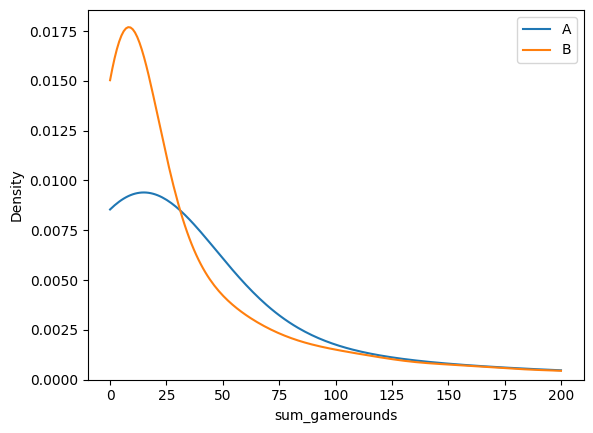

In [52]:
sns.kdeplot(A.sum_gamerounds, clip=(0.0, 200.0), label='A') 
sns.kdeplot(B.sum_gamerounds, clip=(0.0, 200.0), label='B')
plt.legend()

Оценивать прогресс будем с помощью разницы средних, но на средние сильно влияют выбросы. Проверим их наличие.

<Axes: >

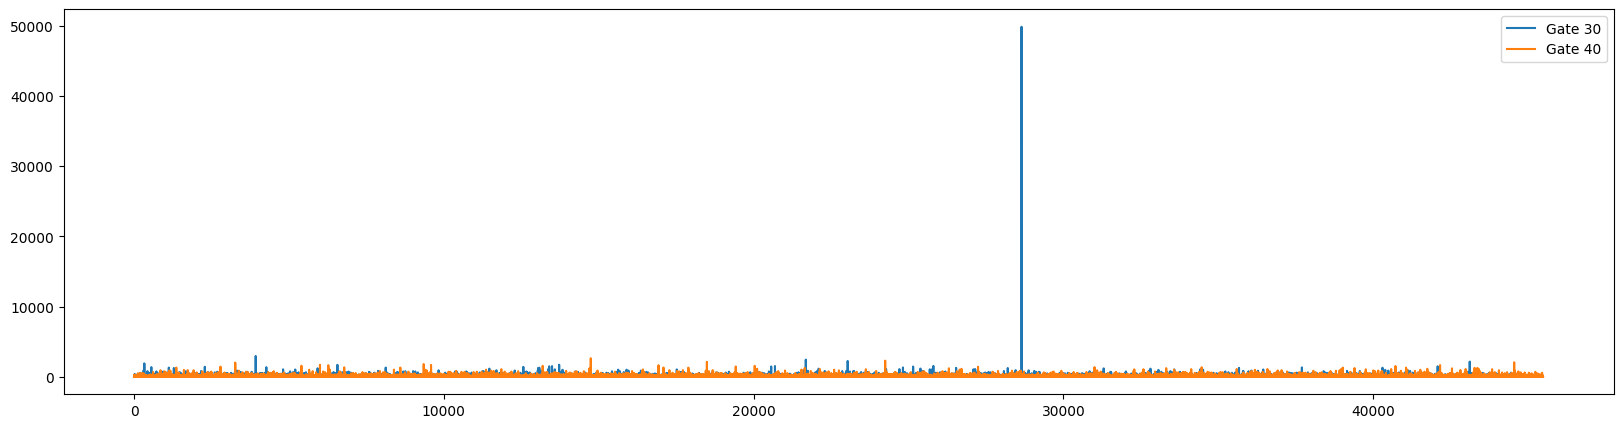

In [53]:
A.sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
B.sum_gamerounds.plot(legend = True, label = "Gate 40")

Можем пожертвовать тем самым максимумом в 49854 раундов

<Axes: >

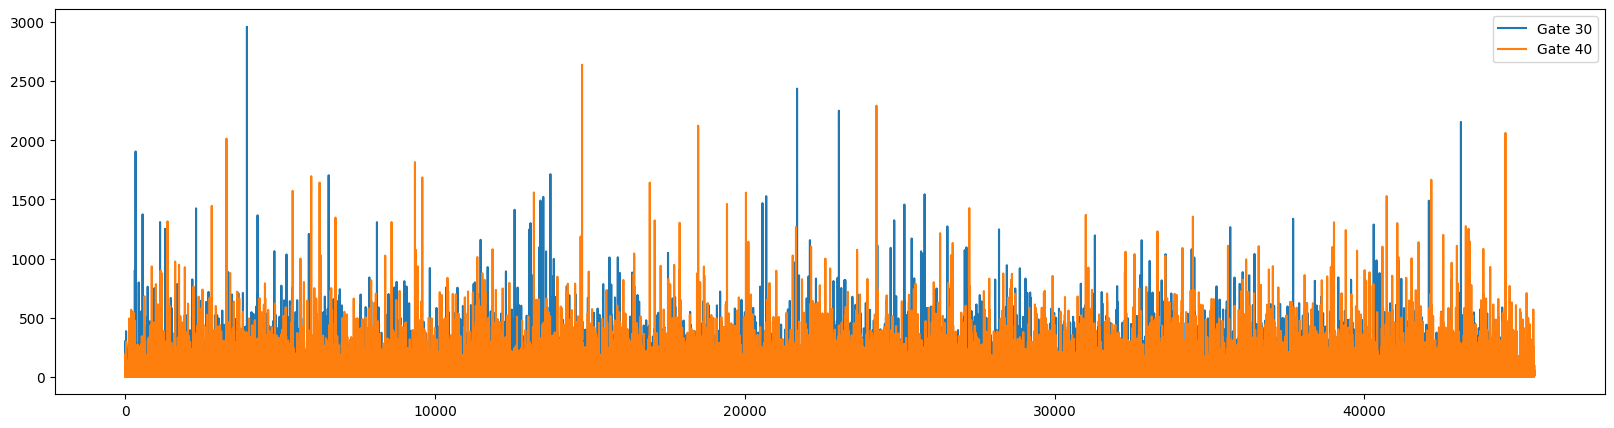

In [4]:
data = data[data.sum_gamerounds < data.sum_gamerounds.max()]
A = data[data.version == "gate_30"].reset_index(drop=True)
B = data[data.version == "gate_40"].reset_index(drop=True)
A.sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
B.sum_gamerounds.plot(legend = True, label = "Gate 40")

In [55]:
data.groupby("version").sum_gamerounds.agg(["count", "median", "max", "mean", "var", "std", cv])

,count,median,max,mean,var,std,cv
version,,,,,,,
gate_30,44699,17.0,2961,51.342111,10415.753288,102.057598,198.779514
gate_40,45489,16.0,2640,51.298776,10669.736422,103.294416,201.358444


Наблюдаем небольшое уменьшение среднего количества пройденных уровней. Воспользуемся статистическим критерием.

### T-критерий Стьюдента: <br>
$H_0: \mu_1 = \mu_2$ — нет статистически значимой разницы<br>
$H_1: \mu_1 \neq \mu_2$

Критерий требует:
- независимости данных (считаем соблюденным)
- нормального распределения средних
- в случае t-критерия Стьюдента требуется равенство дисперсий (для случая неравных дисперсий используются другие вариации критерия)

### 1/3 Проверим нормальность распределения средних

Заметим, что по ЦПТ это верно для многих выборок

100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]


<Axes: ylabel='Density'>

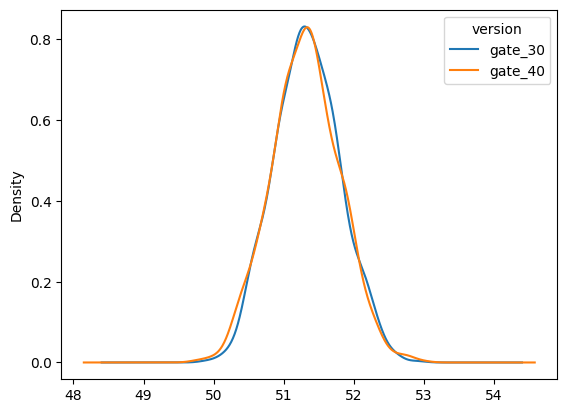

In [57]:
n = 1000
boot = []
for i in tqdm(range(n)):
    boot_mean = data.sample(frac = 1, replace = True).groupby('version').sum_gamerounds.mean()
    boot.append(boot_mean)
boot = pd.DataFrame(boot)
boot[["gate_30", "gate_40"]].plot(kind='density')

Визуально можем оценить, что распределение близко к нормальному, но, чтобы подтвердить это, также воспрользуемся критерием.

#### Тест Шапиро-Уилка<br>
$H_0$ — распределение нормально<br>
$H_1$ — распределение ненормально<br>

$\alpha$ — уровень значимости, вероятность совершить ошибку первого рода (отвергнуть верную $H_0$)<br>
Мы считаем верной нулевую гипотезу, если не было доказано обратное. Считаем, что обратное доказано, если $p-value$ критерия меньше $\alpha$

In [64]:
alpha = 0.05
pvalue = stats.shapiro(boot.gate_30).pvalue
if pvalue < alpha:
    print("Опровергли нормальность распределения. P-value:",  pvalue)
else:
    print("Распределение нормально. P-value:", pvalue)

Распределение нормально. P-value: 0.36139789230919284


In [65]:
pvalue = stats.shapiro(boot.gate_40).pvalue
if pvalue < alpha:
    print("Опровергли нормальность распределения. P-value:",  pvalue)
else:
    print("Распределение нормально. P-value:", pvalue)

Распределение нормально. P-value: 0.7695628400478345


### 2/3 Проверим равенство дисперсий выборок

#### Тест Левена<br>
$H0:$ std_1 = std_2 = ... = std_k<br>
$H1:$ хотя бы в одной группе дисперсия не равна остальным 

In [68]:
stats.levene(A.sum_gamerounds, B.sum_gamerounds).pvalue

0.7840494387892463

### 3/3 Используем T-критерий

In [71]:
alpha = 0.05
pvalue = stats.ttest_ind(A.sum_gamerounds, B.sum_gamerounds, equal_var=True).pvalue
if pvalue < alpha:
    print("Опровергли отсутствие статзначимости разности средних. P-value:",  pvalue)
else:
    print("Разность средних не статзначима. P-value:", pvalue)

Разность средних не статзначима. P-value: 0.9494739458256001


Возьмём синтетические нормально распределённые данные и посмотрим, как выглядело бы отклонение нулевой гипотезы.

In [83]:
N = 1000
normal_data1 = stats.norm(loc=1, scale=2).rvs(size=N)
normal_data2 = stats.norm(loc=4, scale=3).rvs(size=N)

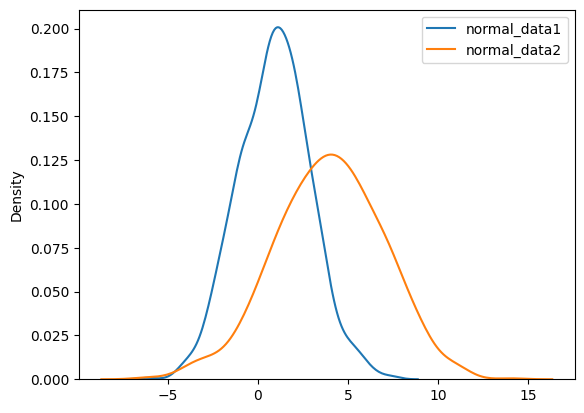

In [84]:
sns.kdeplot(normal_data1, label='normal_data1') 
sns.kdeplot(normal_data2, label='normal_data2')
plt.legend()

In [85]:
pvalue = stats.ttest_ind(normal_data1, normal_data2, equal_var=False).pvalue
if pvalue < alpha:
    print("Опровергли отсутствие статзначимости разности средних. P-value:",  pvalue)
else:
    print("Разность средних не статзначима. P-value:", pvalue)

Опровергли отсутствие статзначимости разности средних. P-value: 1.0508668238359494e-130


# MDE

In [5]:
a_size = 0
sizes = []
pvals = []
while a_size < len(A):
    a_size = min(a_size + 100, len(A))
    b_size = min(a_size, len(B))
    a_sample = A[:a_size].sum_gamerounds
    b_sample = B[:b_size].sum_gamerounds
    sizes.append(a_size)
    pvals.append(stats.ttest_ind(a_sample, b_sample, equal_var=False).pvalue)

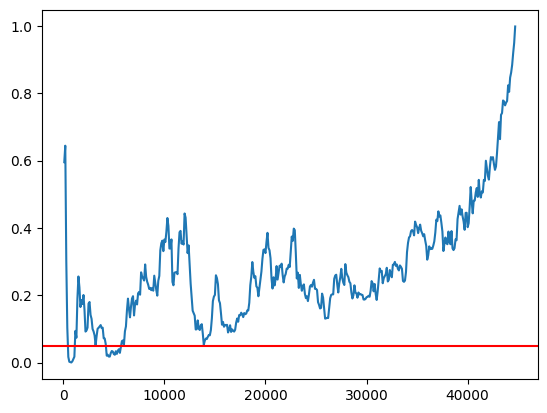

In [8]:
plt.plot(sizes, pvals)
plt.axhline(y=alpha, color='r')
plt.show()

Заметно, что значение p-value колеблется и, имея достаточно маленькую выборку, мы можем ошибочно опровергнуть нулевую гипотезу. Какого размера должна быть выборка?

In [17]:
from statsmodels.stats import power

In [18]:
effect_size = power.TTestIndPower().solve_power(power=0.8,
                                                alpha=0.05,
                                                nobs1=len(A),
                                                ratio=len(B) / len(A),
                                                alternative='two-sided')
effect_size

0.018658644439254257

In [21]:
lift = (B.sum_gamerounds.mean() - A.sum_gamerounds.mean()) / A.sum_gamerounds.mean()
lift

-0.0008440446474390352